In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from adjustText import adjust_text
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.patches import Ellipse

test_metadata = pd.read_csv("data/test_metadata.csv")
train_metadata = pd.read_csv("data/train_metadata.csv")

In [8]:
def print_per_category(df):
    print("*"*30)
    for category in df.category.unique():
        sub_df = df[df.category == category]
        sub_total_success = len(sub_df[sub_df["total_reward"]==1])/len(sub_df)*100
        print(f"{len(sub_df)} {category:<15}: {sub_total_success:.2f} | {sub_df.total_reward.mean():.4f}")

def print_all_results(file_root, file_name):
    df = pd.read_csv(file_root+file_name+"/webshop_scores.csv")
    
    
    df["category"] = train_metadata["category"][:len(df)]
    df["total_success"] = len(df[df["total_reward"]==1])/len(df)
    
    succ_df = df[df["success"]==1]
    # succ_df2 = df2[df2["success"]==1]
    
    print(f"Number of episodes {len(df)}")
    # print(f"Number of successes {df.success.sum()}")
    # print(f"Success Rate {df.success.mean()*100:.2f}")
    print(f"Success Rate {df.total_success.values[0]*100:.2f}")
    print(f"Average Reward {df.total_reward.mean()*100:.2f}")
    print(f"Average Number of Steps Taken {df.num_of_steps.mean():.2f}")
    print(f"Avg. Tokens: {df.total_in_token_accumulated.mean() + df.total_out_token_accumulated.mean():.0f}")
    print(f"Error Rate {df.error.mean()*100:.2f}")
    print_per_category(df)

def load_run_df(file_root, run_name):
    """Load a run CSV, trying webshop_scores.csv then webshop_scores2.csv."""
    p = Path(file_root) / run_name / "webshop_scores.csv"
    return pd.read_csv(p)

def summarize_run(df):
    """Compute metrics used for efficiency comparisons."""
    success_rate = (df["total_reward"] == 1).mean()  # fraction of perfect episodes
    avg_reward   = df["total_reward"].mean()
    avg_steps    = df["num_of_steps"].mean()
    avg_tokens   = (df["total_in_token_accumulated"] + df["total_out_token_accumulated"]).mean()
    error_rate   = df["error"].mean() if "error" in df.columns else float("nan")
    eff_per_1k   = success_rate / (avg_tokens / 1000.0) if avg_tokens > 0 else float("nan")
    return {
        "success_rate": success_rate,         # 0..1
        "avg_reward": avg_reward,             # 0..1 (WebShop score in [0,1])
        "avg_steps": avg_steps,
        "avg_tokens": avg_tokens,             # raw tokens
        "error_rate": error_rate,             # 0..1
        "success_per_1k_tokens": eff_per_1k,  # success per 1k tokens
        "n": len(df),
    }

def collect_metrics(file_root, run_names):
    rows = []
    for name in run_names:
        df = load_run_df(file_root, name)
        m = summarize_run(df)
        m["run"] = name
        rows.append(m)
    return pd.DataFrame(rows)


def _draw_ellipse_cluster(ax, xs, ys, color, alpha=0.12, lw=2, linestyle="--", scale=1.0, min_width=0.5, min_height=3.5):
    """
    Draw a covariance-based ellipse around (xs, ys).
    Works for n >= 2. 'scale' ~2.5 ≈ 95% region for Gaussian-ish blobs.
    min_width/min_height ensure the ellipse isn't collapsed into a line.
    """
    xs = np.asarray(xs); ys = np.asarray(ys)
    if len(xs) < 2:
        return 

    X = np.vstack([xs, ys])
    cov = np.cov(X)  # 2x2
    cov += np.eye(2) * 1e-3

    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # width/height of the ellipse (2 * scale * std)
    width, height = 2 * scale * np.sqrt(vals[0]), 2 * scale * np.sqrt(vals[1])

    # enforce a minimum width/height so it looks like a region instead of a line
    width = max(width, min_width)
    height = max(height, min_height)

    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    center = (xs.mean(), ys.mean())

    e = Ellipse(xy=center, width=width, height=height, angle=angle,
                facecolor=color, edgecolor=color, lw=lw, linestyle=linestyle, alpha=alpha)
    ax.add_patch(e)



def plot_success_vs_tokens(metrics_df, title="Efficiency: Success vs. Tokens (lower x is better)", font_size=11):
    # x: tokens (in K); y: score (%)
    x = (metrics_df["avg_tokens"] / 1000.0).to_numpy()
    y = (metrics_df["avg_reward"] * 100.0).to_numpy()
    labels = metrics_df["run"].tolist()

    # fig, ax = plt.subplots(figsize=(7, 6.5))
    fig, ax = plt.subplots(figsize=(5.5, 5))
    texts = []
    scatters = []
    
    # collect points per variant for cluster ellipses
    groups = {"base": {"x": [], "y": []},
              "rag": {"x": [], "y": []},
              "ft": {"x": [], "y": []},
              "ft_rag": {"x": [], "y": []}}

    for xi, yi, lab in zip(x, y, labels):
        if "ft_rag" in lab:
            variant = "ft_rag"
        elif "ft" in lab:
            variant = "ft"
        elif "rag" in lab:
            variant = "rag"
        else:
            variant = "base"

        c = color_map[variant]
        pretty_label = label_map.get(lab, lab)

        s = ax.scatter(xi, yi, color=c, s=80, edgecolor="black", linewidth=0.6)
        texts.append(ax.text(xi, yi, pretty_label, fontsize=font_size))
        scatters.append(s)  # collect scatter handle
        groups[variant]["x"].append(xi)
        groups[variant]["y"].append(yi)

    # draw ellipses per variant (works for n >= 2)
    for variant, pts in groups.items():
        if len(pts["x"]) >= 2:
            _draw_ellipse_cluster(ax, pts["x"], pts["y"], color=color_map[variant])

    # de-overlap labels
    adjust_text(texts, 
                # add_objects=scatters, 
                expand=(1, 3),
                arrowprops=dict(arrowstyle="->", color="black", lw=0.2),
                lim=1000,                                   # more iterations if needed
               )

    ax.set_xlabel("Average tokens per episode ($10^3$)")
    ax.set_ylabel("Score", fontsize=font_size+1)
    ax.set_title(title, fontsize=font_size+2)
    ax.grid(True, linestyle=":", linewidth=0.8)

    # legend (variants)
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Base',
               markerfacecolor=color_map["base"], markersize=10, markeredgecolor="black"),
        Line2D([0], [0], marker='o', color='w', label='RAG',
               markerfacecolor=color_map["rag"], markersize=10, markeredgecolor="black"),
        Line2D([0], [0], marker='o', color='w', label='SFT',
               markerfacecolor=color_map["ft"], markersize=10, markeredgecolor="black"),
        Line2D([0], [0], marker='o', color='w', label='Distillation',
               markerfacecolor=color_map["ft_rag"], markersize=10, markeredgecolor="black"),
    ]
    ax.legend(handles=legend_elements, title="Variants", fontsize=font_size, title_fontsize=font_size+1)

    plt.tight_layout()
    plt.savefig("test.png", dpi=400)
    plt.show()
    
def print_metrics_table(metrics_df):
    cols = ["run", "n",
            "success_rate", "avg_reward", "avg_steps",
            "avg_tokens", "success_per_1k_tokens", "error_rate"]
    dfp = metrics_df[cols].copy()
    dfp["success_rate"] = (dfp["success_rate"] * 100).map(lambda v: f"{v:.2f}")
    dfp["avg_reward"] = (dfp["avg_reward"] * 100).map(lambda v: f"{v:.2f}")
    dfp["avg_steps"] = dfp["avg_steps"].map(lambda v: f"{v:.2f}")
    dfp["avg_tokens"] = (dfp["avg_tokens"] / 1000.0).map(lambda v: f"{v:.2f}k")
    dfp["success_per_1k_tokens"] = dfp["success_per_1k_tokens"].map(lambda v: f"{v:.3f}")
    dfp["error_rate"] = (dfp["error_rate"] * 100).map(lambda v: f"{v:.2f}") if dfp["error_rate"].notna().all() else dfp["error_rate"]
    print("\n=== Efficiency Summary ===")
    print(dfp.to_string(index=False))
    
label_map = {
    "act": "Act",
    "act_rag": "Act+RAG",
    "act_ft": "Act+SFT",
    "act_ft_rag": "Act+Distillation",
    "act_rag_ft": "Act+SFT+RAG",          
    "act_rag_ft_rag": "Act+Distillation+RAG", 
    "state": "State",
    "state_rag": "State+RAG",
    "state_ft": "State+SFT",
    "state_ft_rag": "State+Distillation",
    "state_rag_ft": "State+SFT+RAG",
    "state_rag_ft_rag": "State+Distillation+RAG",
}

# Color scheme for Act and State variants
color_map = {
    "base": "tab:blue",
    "rag": "tab:orange",
    "ft": "tab:green",
    "ft_rag": "tab:red",
}


=== Efficiency Summary ===
         run   n success_rate avg_reward avg_steps avg_tokens success_per_1k_tokens error_rate
         act 100        37.00      61.51      6.24      5.51k                 0.067      22.00
     act_rag 100        43.00      66.97      5.91      9.31k                 0.046      21.00
      act_ft 100        42.00      71.40      5.03      3.63k                 0.116       2.00
  act_ft_rag 100        43.00      72.32      4.96      3.51k                 0.122       1.00
       state 100        40.00      60.12      8.08     10.50k                 0.038      99.00
   state_rag 100        44.00      67.18      6.76     12.79k                 0.034      46.00
    state_ft 100        44.00      72.78      4.96      4.95k                 0.089       6.00
state_ft_rag 100        44.00      72.49      4.99      5.02k                 0.088       6.00


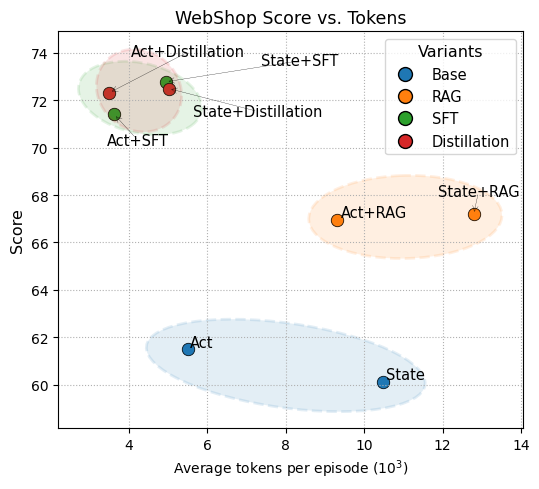

In [9]:
# Usage:
file_root = "game_logs"
run_names = [
    "act",
    "act_rag",
    "act_ft",
    "act_ft_rag",
    "state",
    "state_rag",
    "state_ft",
    "state_ft_rag"
]

metrics = collect_metrics(file_root, run_names)
print_metrics_table(metrics)
plot_success_vs_tokens(metrics, title="WebShop Score vs. Tokens", font_size=10.5)

In [41]:
run_names = [
    "7B_act",
    "7B_act_rag",
    "7B_act_ft",
    "7B_act_ft_rag",
    "7B_state",
    "7B_state_rag",
    "7B_state_ft",
    "7B_state_ft_rag"
]

print_metrics_table(collect_metrics("game_logs", run_names))


=== Efficiency Summary ===
            run   n success_rate avg_reward avg_steps avg_tokens success_per_1k_tokens error_rate
         7B_act 100        19.00      44.05      7.89      9.36k                 0.020      38.00
     7B_act_rag 100         9.00      28.80     10.07     22.02k                 0.004      56.00
      7B_act_ft 100        22.00      44.25      8.50      8.18k                 0.027      43.00
  7B_act_ft_rag 100        31.00      57.11      7.15      5.95k                 0.052      63.00
       7B_state 100         5.00      12.18     13.41     32.84k                 0.002      97.00
   7B_state_rag 100         4.00       8.12     13.76     54.74k                 0.001      88.00
    7B_state_ft 100        38.00      64.51      5.65      6.90k                 0.055      13.00
7B_state_ft_rag 100        39.00      64.97      5.74      6.55k                 0.059      16.00


In [43]:
run_names = ["act_rag","act_rag_bm25", "act_rag_tfidf",
            "state_rag", "state_rag_bm25", "state_rag_tfidf"]

print_metrics_table(collect_metrics("game_logs", run_names))


=== Efficiency Summary ===
            run   n success_rate avg_reward avg_steps avg_tokens success_per_1k_tokens error_rate
        act_rag 100        43.00      66.97      5.91      9.31k                 0.046      21.00
   act_rag_bm25 100        44.00      66.38      6.65      6.56k                 0.067      30.00
  act_rag_tfidf 100        44.00      66.38      6.65      6.56k                 0.067      30.00
      state_rag 100        44.00      67.18      6.76     12.79k                 0.034      46.00
 state_rag_bm25 100        45.00      63.87      7.71     12.51k                 0.036      40.00
state_rag_tfidf 100        45.00      63.87      7.71     12.51k                 0.036      40.00


In [23]:
run_names = [
    "act_rag_1hint",
    "act_rag",
    "act_rag_6hint",
    "act_rag_9hint",
    "state_rag_1hint",
    "state_rag",
    "state_rag_6hint",
    "state_rag_9hint",
]

print_metrics_table(collect_metrics("game_logs", run_names))


=== Efficiency Summary ===
            run   n success_rate avg_reward avg_steps avg_tokens success_per_1k_tokens error_rate
  act_rag_1hint 100        41.00      66.13      6.01      9.46k                 0.043      17.00
        act_rag 100        43.00      66.97      5.91      9.31k                 0.046      21.00
  act_rag_6hint 100        40.00      63.00      6.53     10.46k                 0.038      23.00
  act_rag_9hint 100        38.00      59.77      7.16     11.81k                 0.032      28.00
state_rag_1hint 100        40.00      63.32      6.89     12.62k                 0.032      34.00
      state_rag 100        44.00      67.18      6.76     12.79k                 0.034      46.00
state_rag_6hint 100        40.00      60.60      7.35     15.03k                 0.027      36.00
state_rag_9hint 100        43.00      62.47      7.15     14.43k                 0.030      32.00


In [31]:
import pandas as pd
import numpy as np
from pathlib import Path

# ---- Config ----
file_root = "game_logs"
# run_names = [
#     "act",
#     "act_rag",
#     "act_ft",
#     "act_ft_rag",
#     "state",
#     "state_rag",
#     "state_ft",
#     "state_ft_rag"
# ]

run_names = [
    "act_rag_1hint",
    "act_rag",
    "act_rag_6hint",
    "act_rag_9hint",
    "state_rag_1hint",
    "state_rag",
    "state_rag_6hint",
    "state_rag_9hint"
]

# Map the short run key -> (agent, method)
# short key is the part after the first '/'
key_map = {
    "act":            ("react", "Base"),
    "act_rag":        ("react", "RAG"),
    "act_rag_1hint":  ("react", "RAG-1"),
    "act_rag_6hint":  ("react", "RAG-6"),
    "act_rag_9hint":  ("react", "RAG-9"),
    "act_ft":         ("react", "SFT"),
    "act_ft_rag":     ("react", "Distillation"),
    "state":            ("state", "Base"),
    "state_rag":        ("state", "RAG"),
    "state_rag_1hint":  ("state", "RAG-1"),
    "state_rag_6hint":  ("state", "RAG-6"),
    "state_rag_9hint":  ("state", "RAG-9"),
    "state_ft":         ("state", "SFT"),
    "state_ft_rag":     ("state", "Distillation"),
}

# Pretty order/labels for ALFWorld env types
type_display_map = {
    "beauty": "Beauty",
    "fashion": "Fashion",
    "garden": "Furniture",
    "electronics": "Electronics",
    "grocery": "Food",
}
type_order = ["Beauty", "Electronics", "Fashion", "Food", "Furniture"]
method_order = ["Base", "RAG", "SFT", "Distillation"]

test_metadata = pd.read_csv("data/test_metadata.csv")

def load_run_df(root, run_path):
    p = Path(root) / run_path / "webshop_scores.csv"
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")
    return pd.read_csv(p)

def per_type_success(df):
    # success defined as total_reward == 1
    g = df.groupby("category").agg(
        n=("category", "size"),
        avg_score=("total_reward", "mean")
    ).reset_index()
    # g["succ_rate"] = (g["reward"] / g["n"]) * 100.0
    g["avg_score"] = g["avg_score"]*100
    # normalize type names
    g["Type"] = g["category"].map(type_display_map).fillna(g["category"])
    return g[["Type", "n", "avg_score"]]

# Collect per-type stats for each (agent, method)
stats = {}  # stats[(agent, method)] = DataFrame(Type, n, succ_rate)
print("\n==== Per-run per-type success (for sanity) ====")
for rp in run_names:
    short = rp
    agent, method = key_map[short]
    df = load_run_df(file_root, rp)
    df["category"] = test_metadata["category"][:len(df)]
    g = per_type_success(df)
    stats[(agent, method)] = g

    print(f"\n[{short}]")
    for _, r in g.sort_values("Type").iterrows():
        print(f"{r['Type']:<8}  n={int(r['n']):>4}  success={r['avg_score']:.2f}%")

# Build the table: average across agents for each method, per Type
rows = []
for T in type_order:
    row = {"Type": T}
    for method in method_order:
        # fetch react + state rows for this type/method
        vals = []
        for agent in ["react", "state"]:
            g = stats.get((agent, method))
            if g is None:
                continue
            sub = g[g["Type"] == T]
            if not sub.empty:
                vals.append(float(sub["avg_score"].iloc[0]))
        # average across available agents
        row[method] = np.mean(vals) if len(vals) else np.nan
    rows.append(row)

table_df = pd.DataFrame(rows).set_index("Type")

# Weighted "Mean" across all types & both agents for each method
def weighted_method_mean(method):
    total_succ = 0.0
    total_n = 0
    for agent in ["react", "state"]:
        g = stats.get((agent, method))
        if g is None:
            continue
        total_succ += (g["avg_score"] / 100.0 * g["n"]).sum()
        total_n += g["n"].sum()
    return (total_succ / total_n) * 100.0 if total_n > 0 else np.nan

mean_row = {m: weighted_method_mean(m) for m in method_order}
table_df.loc["\\textbf{Mean}"] = [mean_row[m] for m in method_order]

# Print LaTeX table block
def to_latex_block(df):
    lines = []
    for idx in type_order + ["\\textbf{Mean}"]:
        if idx not in df.index:  # safety
            continue
        vals = [df.loc[idx, m] for m in method_order]
        vals_str = " & ".join(f"{v:.2f}" for v in vals)
        lines.append(f"    {idx:<8} & {vals_str} \\\\")
    body = "\n".join(lines)
    latex = rf"""
\begin table [H]
  \centering
  \caption{{Average of both agents' performance on WebSHop, shown per category type, using a 14B backbone.}}
  \label{{tab:webshop-pertype-compact}}
  \begin tabular {{lcccc}}
    \toprule
    \multicolumn{{1}}{{c}}{{\textbf{{Type}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{Base}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{RAG}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{SFT}}}} &
    \multicolumn{{1}}{{c}}{{\textbf{{Distillation}}}} \\
    \midrule
{body}
    \bottomrule
  \end tabular 
\end table 
""".strip("\n")
    return latex

print("\n==== LaTeX table ====")
print(to_latex_block(table_df.round(2)))



==== Per-run per-type success (for sanity) ====

[act_rag_1hint]
Beauty    n=  31  success=64.09%
Electronics  n=  21  success=70.79%
Fashion   n=  14  success=68.81%
Food      n=  15  success=63.33%
Furniture  n=  19  success=64.56%

[act_rag]
Beauty    n=  31  success=63.01%
Electronics  n=  21  success=68.81%
Fashion   n=  14  success=68.81%
Food      n=  15  success=70.00%
Furniture  n=  19  success=67.63%

[act_rag_6hint]
Beauty    n=  31  success=60.59%
Electronics  n=  21  success=68.41%
Fashion   n=  14  success=68.81%
Food      n=  15  success=62.33%
Furniture  n=  19  success=57.19%

[act_rag_9hint]
Beauty    n=  31  success=57.63%
Electronics  n=  21  success=65.95%
Fashion   n=  14  success=59.52%
Food      n=  15  success=67.44%
Furniture  n=  19  success=50.53%

[state_rag_1hint]
Beauty    n=  31  success=64.14%
Electronics  n=  21  success=68.57%
Fashion   n=  14  success=52.38%
Food      n=  15  success=67.67%
Furniture  n=  19  success=60.79%

[state_rag]
Beauty    n=

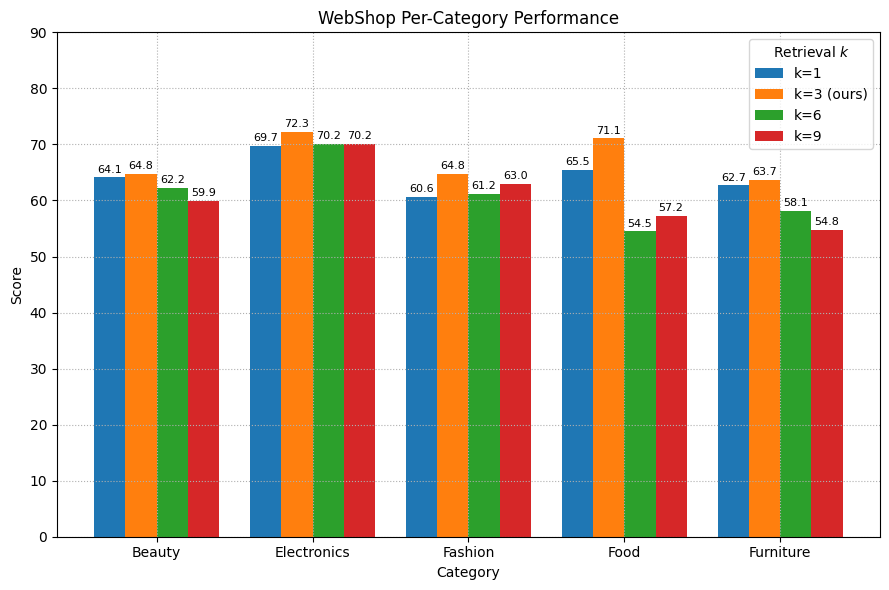

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your LaTeX table
categories = ["Beauty", "Electronics", "Fashion", "Food", "Furniture"]
k1 = [64.12, 69.68, 60.60, 65.50, 62.68]
k3 = [64.76, 72.26, 64.76, 71.06, 63.69]
k6 = [62.21, 70.16, 61.19, 54.50, 58.12]
k9 = [59.92, 70.16, 62.98, 57.22, 54.79]

methods = {
    "k=1": k1,
    "k=3 (ours)": k3,
    "k=6": k6,
    "k=9": k9,
}

color_map = {
    "k=1": "tab:blue",
    "k=3 (ours)": "tab:orange",
    "k=6": "tab:green",
    "k=9": "tab:red",
}


# # Data from your LaTeX table
# categories = ["Beauty", "Electronics", "Fashion", "Food", "Furniture"]
# base =   [61.48, 64.09, 60.06, 59.99, 57.32]
# rag =    [64.76, 72.26, 64.76, 71.06, 63.68]
# ft =     [70.91, 74.60, 68.57, 67.86, 77.15]
# ft_rag = [71.61, 78.97, 67.38, 61.31, 78.90]

# methods = {
#     "Base": base,
#     "RAG": rag,
#     "SFT": ft,
#     "Distillation": ft_rag,
# }

# color_map = {
#     "Base": "tab:blue",
#     "RAG": "tab:orange",
#     "SFT": "tab:green",
#     "Distillation": "tab:red",
# }

# Plot config
x = np.arange(len(categories))  # positions
width = 0.2                     # bar width

fig, ax = plt.subplots(figsize=(9, 6))
ax.grid(True, linestyle=":", linewidth=0.8)

# Plot each method as a group
for i, (method, values) in enumerate(methods.items()):
    ax.bar(
        x + i*width - 1.5*width,  # center the groups
        values,
        width,
        label=method.replace("_", "+"),
        color=color_map[method]
    )

# Labels and style
ax.set_ylabel("Score")
ax.set_xlabel("Category")
ax.set_ylim(0, 90)
ax.set_title("WebShop Per-Category Performance")
ax.set_xticks(x)
ax.set_xticklabels(categories)
# ax.set_ylim(0, 105)  # give headroom above 100
ax.legend(title="Retrieval $k$")

# Annotate bar values
for bars in ax.containers:
    ax.bar_label(bars, fmt="%.1f", padding=2, fontsize=8)

plt.tight_layout()
plt.savefig("webshop_pertype_bar.png", dpi=400)
plt.show()
